# Ex01 : Generation using GENIE

In this tutorial, we'll walk through a bash script that generates neutrino events using GENIE (Generates Events for Neutrino Interaction Experiments). The script in `interactive/GENIEv3_MINERvA.sh` sets up parameters such as the random seed, incoming neutrino properties, flux histograms, target material, number of events to generate, energy range, physics model, and output file name. Here we will run the same analysis, but in a Jupyter notebook and analyse the output using PyROOT.

### Prerequisites
Before starting, ensure you have GENIE installed on your system. You can find installation instructions on the [GENIE website](https://genie.hepforge.org/). If you are using the NUISANCE tutorial container it is already installed and setup for you.

### Script Breakdown

Let's dissect the script step by step:

```bash
## The random seed used to generate events. This will use the local time.
## Note that if you generate a large number of events split into many jobs,
## more complex seeding may be required to ensure there are no duplicates
THIS_SEED=0
```

Here, the random seed (`THIS_SEED`) is set to 0. The seed is used for event generation, ensuring reproducibility.

```bash
## The PDG code of the incoming neutrino
NU_PDG=14
```

The PDG code (`NU_PDG`) represents the incoming neutrino. In this case, it's set to 14, which corresponds to a muon neutrino.

```bash
## The flux histograms to use
FLUX_FILE=/opt/nuisance/data/flux/minerva_le_flux.root
FLUX_HIST=numu_fhc
```

These lines specify the flux histograms to use. `FLUX_FILE` points to the location of the flux file, while `FLUX_HIST` selects a specific flux histogram.

```bash
## The target material
TARG=1000060120[0.9231],1000010010[0.0769]
```

The target material (`TARG`) is defined here. It represents the composition of the target in terms of atomic numbers and weights.

```bash
## The number of events to generate
NEVENTS=100000
```

`NEVENTS` sets the number of events to generate, in this case, 100,000.

```bash
## The maximum and minimum neutrino energies to simulate
E_MIN=0.1
E_MAX=50
```

These lines define the range of neutrino energies (`E_MIN` to `E_MAX`) to simulate.

```bash
## The physics model "tune" to generate events with, and a set of 
## pre-calculated cross-section "splines" used to massively reduce
## The necessary computational time required.
TUNE=AR23_20i_00_000
XSEC_SPLINES=MC_inputs/${TUNE}_v340_splines.xml.gz
```

Here, the physics model `TUNE` is set, along with pre-calculated cross-section "splines" in `XSEC_SPLINES`.

```bash
## The output file name
OUTFILE=GENIEv3_AR23_MINERvA_LE_FHC_numu.root
```

`OUTFILE` specifies the name of the output file.

```bash
## This uses GENIE's gevgen application
echo "Starting gevgen..."
gevgen -n ${NEVENTS} -t ${TARG} -p ${NU_PDG} \
       --cross-sections ${XSEC_SPLINES} \
       --tune ${TUNE} --seed ${THIS_SEED} \
       -f ${FLUX_FILE},${FLUX_HIST} -e ${E_MIN},${E_MAX} -o ${OUTFILE} &> /dev/null
```

Finally, the script executes GENIE's `gevgen` application with the specified parameters. We can run all that as a single command in a Jupyter bash cell using the command below.

In [1]:
# BASH COMMAND
!gevgen -n 100000 \
    -t 1000060120[0.9231],1000010010[0.0769] \
    -p 14 \
    --cross-sections MC_inputs/AR23_20i_00_000_v340_splines.xml.gz \
    --tune AR23_20i_00_000 \
    --seed 0 \
    -f /opt/nuisance/data/flux/minerva_le_flux.root,numu_fhc \
    -o MC_outputs/GENIEv3_AR23_MINERvA_LE_FHC_numu.root \
    -e 0.1,50.0 > /dev/null

### Using NUISANCE for Further Analysis

After generating neutrino events with GENIE, the script proceeds to utilize NUISANCE applications for additional analysis steps. Let's break down the next step:

```bash
## The next two steps use NUISANCE applications
echo "Starting PrepareGENIE..."
PrepareGENIE -i $OUTFILE -f ${FLUX_FILE},${FLUX_HIST} \
	     -t $TARG -o ${OUTFILE/.root/_NUIS.root}
```

   - **Command**: `PrepareGENIE` is a NUISANCE application used for preparing GENIE output files for further analysis.
   - **Options**:
     - `-i $OUTFILE`: Specifies the input GENIE output file generated in the previous step.
     - `-f ${FLUX_FILE},${FLUX_HIST}`: Specifies the flux histograms to be used for simulation.
     - `-t $TARG`: Specifies the target material used in the simulation.
     - `-o ${OUTFILE/.root/_NUIS.root}`: Specifies the output file name for the prepared GENIE file. Here, `.root` in the original filename is replaced with `_NUIS.root`.

This step prepares the GENIE output file for subsequent analysis using NUISANCE tools. It ensures that the necessary configurations and formats are applied to the output file for accurate analysis and interpretation.

In [2]:
# BASH COMMAND
!PrepareGENIE -i MC_outputs/GENIEv3_AR23_MINERvA_LE_FHC_numu.root \
    -f /opt/nuisance/data/flux/minerva_le_flux.root,numu_fhc \
	-t 1000060120[0.9231],1000010010[0.0769] \
    -o MC_outputs/GENIEv3_AR23_MINERvA_LE_FHC_numu_NUIS.root

Nuisance: Neutrino Interaction Synthesiser from A-Neutrino sCattering Experiments  -- Playing on the comparisons you want to see
[ NUISANCE ]: Loading DEFAULT settings from : /opt/nuisance/parameters/config.xml
[ NUISANCE ]: Finished nuisconfig.
[ NUISANCE ]: Setting VERBOSITY=4
[ NUISANCE ]: Setting ERROR=2
[LOG Fitter]: Running GENIE Prepare with flux...
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for /opt/neut-src/neutclass/neutctrl.h
   requested to autoload type NeutCtrl
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for /opt/neut-src/neutclass/neutfsipart.h
   requested to autoload type NeutFsiPart
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for /opt/neut-src/neutclass/neutfsivert.h
   requested to autoload type NeutFsiVert
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for /opt/neut-src/neutclass/neutnucfsistep.h
   request

### Creating NUISANCE Flat Trees

After preparing the GENIE output file for further analysis with NUISANCE, the script proceeds to create NUISANCE flat trees. Let's understand this step:

```bash
echo "Creating NUISANCE flat trees"
nuisflat -f GenericVectors -i GENIE:${OUTFILE/.root/_NUIS.root} -o ${OUTFILE/.root/_NUISFLAT.root}
```

   - **Command**: `nuisflat` is a NUISANCE application used to create flat trees for further analysis.
   - **Options**:
     - `-f GenericVectors`: Specifies the type of flat trees to create. In this case, it indicates the use of generic vectors.
     - `-i GENIE:${OUTFILE/.root/_NUIS.root}`: Specifies the input file for creating flat trees. Here, the prepared GENIE output file is used.
     - `-o ${OUTFILE/.root/_NUISFLAT.root}`: Specifies the output file name for the created flat trees. Here, `.root` in the original filename is replaced with `_NUISFLAT.root`.

This step generates NUISANCE flat trees from the prepared GENIE output file. These flat trees are structured data formats that simplify subsequent analysis tasks by organizing data into easily accessible formats, facilitating efficient analysis with NUISANCE tools.

In [3]:
# BASH COMMAND
!nuisflat -f GenericVectors \
    -i GENIE:MC_outputs/GENIEv3_AR23_MINERvA_LE_FHC_numu_NUIS.root \
    -o MC_outputs/GENIEv3_AR23_MINERvA_LE_FHC_numu_NUISFLAT.root

Nuisance: Neutrino Interaction Systematics Aggregating New by Comparing Experiments  -- Fit and compare.
[ NUISANCE ]: Loading DEFAULT settings from : /opt/nuisance/parameters/config.xml
[ NUISANCE ]: Finished nuisconfig.
[LOG Fitter]:  : nuisflat.cxx::GetCommandLineArgs[l. 102] : Reading Input File = GENIE:MC_outputs/GENIEv3_AR23_MINERvA_LE_FHC_numu_NUIS.root
[LOG Fitter]:  : nuisflat.cxx::GetCommandLineArgs[l. 111] : Saving flattree in format = GenericVectors
[LOG Fitter]:  : nuisflat.cxx::GetCommandLineArgs[l. 121] : Saving nuisflat output to MC_outputs/GENIEv3_AR23_MINERvA_LE_FHC_numu_NUISFLAT.root
[ NUISANCE ]: Setting VERBOSITY=4
[ NUISANCE ]: Setting ERROR=2
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for /opt/neut-src/neutclass/neutctrl.h
   requested to autoload type NeutCtrl
Error in cling::AutoLoadingVisitor::InsertIntoAutoLoadingState:
   Missing FileEntry for /opt/neut-src/neutclass/neutfsipart.h
   requested to autoload type NeutFs

# PyROOT Output Processing

Now that we have created a NUISANCE flat tree we can plot different generator level quantities in a standard way. An example is given using python in the code below. The advantage of this is the analysis can be repeated for any generator by simple changing the ROOT TFile to point at another NUISANCE flat tree that has been created from the raw generator outputs.

In [12]:
import ROOT
f = ROOT.TFile("MC_outputs/GENIEv3_AR23_MINERvA_LE_FHC_numu_NUISFLAT.root","READ")
f.ls()

TFile**		MC_outputs/GENIEv3_AR23_MINERvA_LE_FHC_numu_NUISFLAT.root	
 TFile*		MC_outputs/GENIEv3_AR23_MINERvA_LE_FHC_numu_NUISFLAT.root	
  KEY: TTree	FlatTree_VARS;2	FlatTree_VARS [current cycle]
  KEY: TTree	FlatTree_VARS;1	FlatTree_VARS [backup cycle]
  KEY: TH1F	FlatTree_FLUX;1	FlatTree_FLUX
  KEY: TH1F	FlatTree_EVT;1	FlatTree_EVT


Inside each file you'll see we have a TTree, and the FLUX and Event Rate (EVT) histograms. NUISANCE needs this to properly determine either flux averaged or flux unfolded cross-sections. They are calculated at the Prepare stage but included here in case you need it.

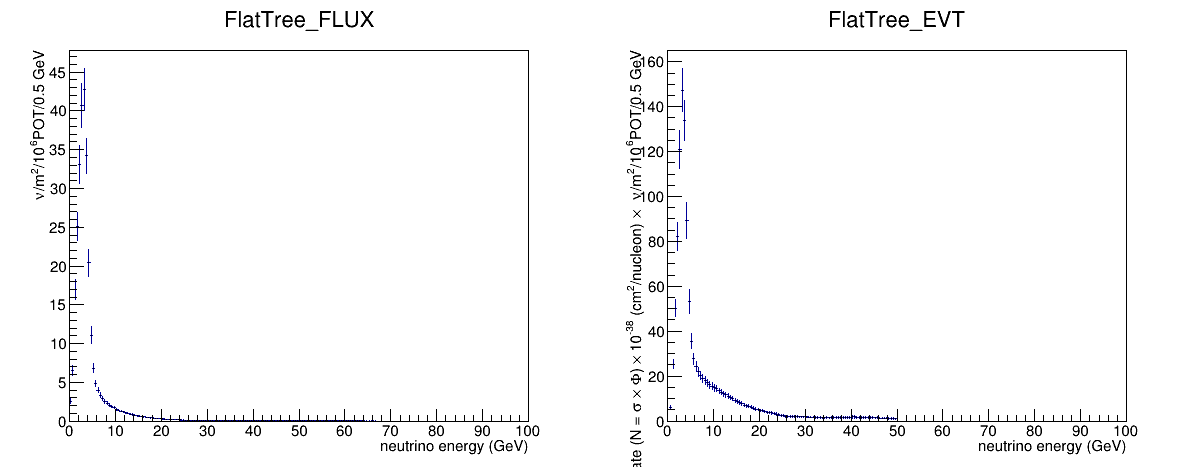

In [5]:
c1 = ROOT.TCanvas("c1","c1",1200,500)
c1.Divide(2,1)

c1.cd(1)
f.FlatTree_FLUX.Draw()

c1.cd(2)
f.FlatTree_EVT.Draw()

c1.Draw()

The most important thing in the file is the FlatTree itself. This contains a list of all particles in the event alongside a set of precalculated quantities of interest.

In [6]:
fvs = f.Get("FlatTree_VARS")
fvs.Show(0)

======> EVENT:0
 Mode            = 13
 GENIEResCode    = 1
 cc              = 1
 PDGnu           = 14
 Enu_true        = 6.47989
 tgt             = 1000060120
 tgta            = 12
 tgtz            = 6
 PDGLep          = 13
 ELep            = 5.44298
 CosLep          = 0.99638
 Q2              = 0.257467
 q0              = 1.03691
 q3              = 1.15441
 Enu_QE          = 5.59825
 Q2_QE           = 0.220916
 W_nuc_rest      = 1.60272
 W               = 1.60272
 W_genie         = -99999
 x               = 0.132318
 y               = 0.16002
 Erecoil_minerva = 0.348163
 Erecoil_charged = 0.348163
 EavAlt          = 0.353983
 Emiss           = 0.00582003
 pmiss           = (TVector3*)0x5625675177a0
 Emiss_preFSI    = 0.0108064
 pmiss_preFSI    = (TVector3*)0x56256752c590
 CosThetaAdler   = -999.9
 PhiAdler        = -999.9
 dalphat         = 2.36496
 dpt             = 764.951
 dphit           = 1.72432
 pnreco_C        = 1.07934
 nfsp            = 4
 px              = -0.0835399, 
    

Some interesting ones are:
- `Mode` : NEUT Interaction code. Other generators are converted into this (+-1 CCQE, +-2 2p2h, etc).
- `flagXXX`: Different final state topoology selections.
- `fScaleFactor`: A weighting factor that can be used to convert all predictions into flux averaged total cross-sections.
- `px,py,pz,E,pdg`: List of final state particle momenta, energies, and pdgs.
- `q0,q3,Q2`: Momentum transfer information.

In the cell below as an example we draw the true neutrino energy distribution for all events in our small flat tree.

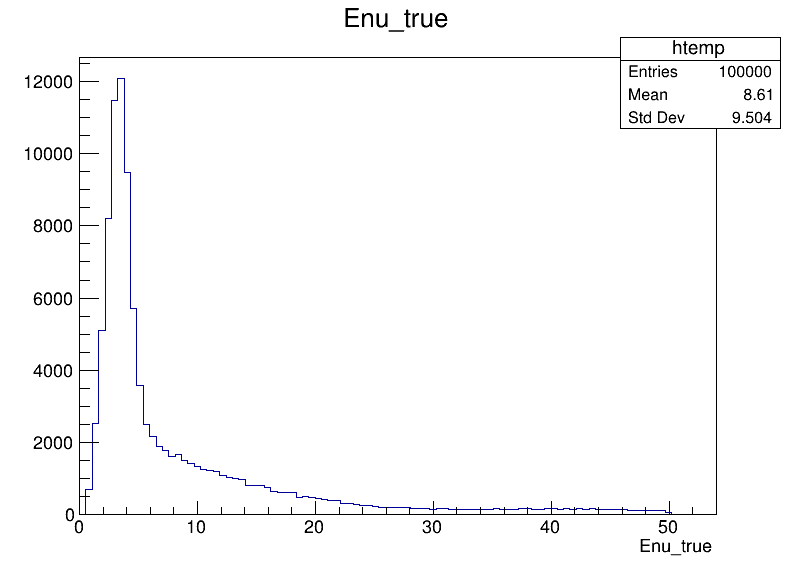

In [7]:
c2 = ROOT.TCanvas("c2","c2",800,600)
c2.cd()
fvs.Draw("Enu_true")
c2.Draw()

We can also do things like plot `q0` vs `q3` for an event using standard TTree draw commands.

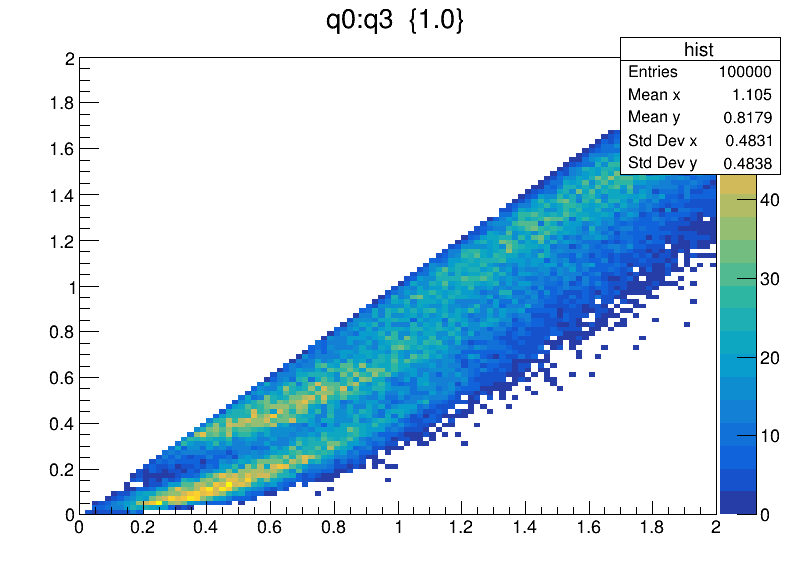

In [8]:
c3 = ROOT.TCanvas("c3","c3",800,600)
fvs.Draw("q0:q3 >> hist(100,0.0,2.0,100,0.0,2.0)","1.0","COLZ")
c3.Draw()

Those topology flags we discussed earlier can come in handy for event selections.

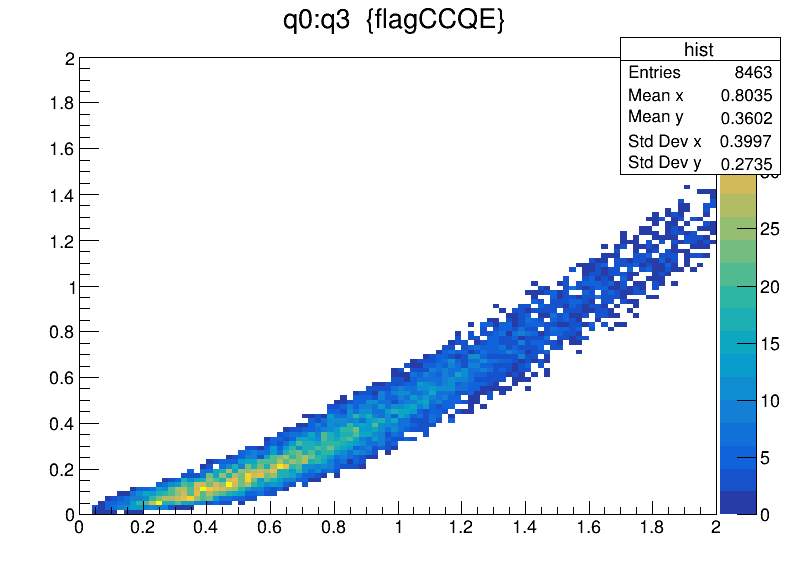

In [9]:
c4 = ROOT.TCanvas("c4","c4",800,600)
fvs.Draw("q0:q3 >> hist(100,0.0,2.0,100,0.0,2.0)","flagCCQE","COLZ")
c4.Draw()

Or we can even write our own based on event selections. The TTree draw `Sum$()` function comes in very handy for these. The command below draws any event where at least one positive pion with an energy greater than 200 MeV is observed in the event.

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c5


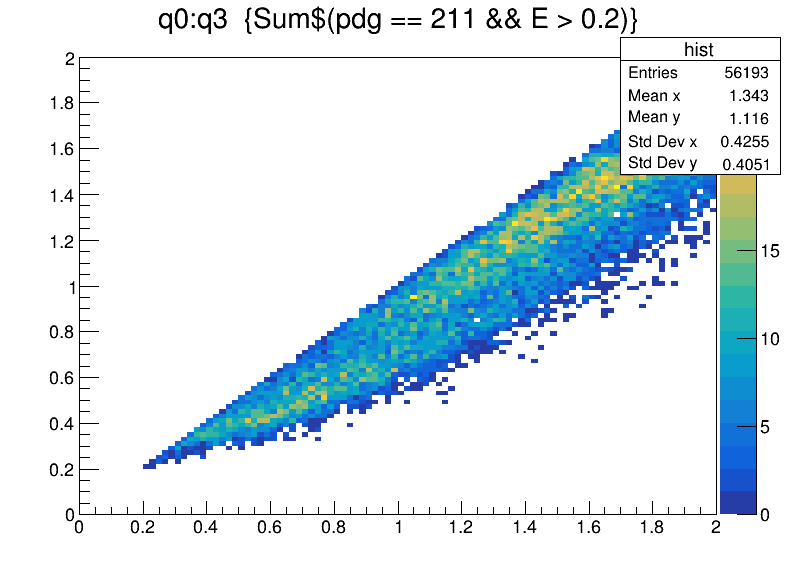

In [11]:
c5 = ROOT.TCanvas("c5","c5",800,600)
fvs.Draw("q0:q3 >> hist(100,0.0,2.0,100,0.0,2.0)","Sum$(pdg == 211 && E > 0.2)","COLZ")
c5.Draw()

That concludes our overview of NUISANCE FlatTree features. For comparing multiple generators using flattree files please see later tutorials.